Met dit project willen wij de brandende vraag beantwoorden of Ajax inderdaad bestaat uit mooiweervoetballers. Hiervoor is gekeken naar de eredivisie uitslagen vanaf seizoen 2008-2009 tot 2018-2019. De data is afkomstig van www.koningvoetbal.nl. De weerdata is afkomstig van http://projects.knmi.nl/klimatologie/daggegevens/selectie.cgi 
Als afhankelijke variabelen gaan we kijken naar het resultaat (winst, gelijk, verlies), het aantal doelpunten voor/tegen en het doelsaldo. Als voorspellers gaan we kijken naar o.a. temperatuur, neerslag en zonuren. 
Uiteraard krijgen we te maken met messy data en moet er eerst het een en ander geprepareed worden. Goede manier om mijn Python-zwaard te slijpen. 

In [68]:
# importeren libraries

import numpy as np 
import pandas as pd
import scipy as sp
import datetime as dt
import re
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib as plt
import seaborn as sns
%matplotlib inline 


In [38]:
# importeren dataset Ajax scores (lokaal opgesglagen). 
df = pd.read_excel("mooiweervoetballers koningvoetbal.xlsx", index_col=None, header=None)


In [39]:
# columnames toevoegen
df.columns = ["Speeldag","Datum","Teams","Uitslag"]


In [40]:
# structuur checken 1
df.head()


,Speeldag,Datum,Teams,Uitslag
0,Zo,2008-09-14,Ajax - Roda JC,1-0
1,Zo,2008-09-28,Ajax - Vitesse,3-0
2,Za,2008-10-18,Ajax - FC Groningen,1-0
3,Zo,2008-10-26,Ajax - NEC,2-0
4,Zo,2008-11-09,Ajax - Sparta Rotterdam,5-2


In [41]:
# structuur checken 2
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 4 columns):
Speeldag    340 non-null object
Datum       340 non-null datetime64[ns]
Teams       340 non-null object
Uitslag     340 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 10.7+ KB


In [42]:
# checken of er missings zijn 
df.sum().isna()

Speeldag    False
Teams       False
Uitslag     False
dtype: bool

In [43]:
df2 = pd.read_csv("mooiweervoetballersedit.csv")

In [44]:
# columnames toevoegen
df2.columns = ["Datum","meantemp","mintemp","maxtemp","zonuur","neerslagduur","etmaalneers","bewolkgraad"]

In [45]:
# check
df2.head(5)

,Datum,meantemp,mintemp,maxtemp,zonuur,neerslagduur,etmaalneers,bewolkgraad
0,20080814,151,95,206,70,7,1,3.0
1,20080815,147,83,212,108,5,40,1.0
2,20080816,159,68,228,109,0,0,2.0
3,20080817,163,132,218,9,15,90,8.0
4,20080818,161,135,191,5,96,132,8.0


In [46]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3927 entries, 0 to 3926
Data columns (total 8 columns):
Datum           3927 non-null int64
meantemp        3927 non-null int64
mintemp         3927 non-null int64
maxtemp         3927 non-null int64
zonuur          3927 non-null int64
neerslagduur    3927 non-null int64
etmaalneers     3927 non-null int64
bewolkgraad     3918 non-null float64
dtypes: float64(1), int64(7)
memory usage: 245.5 KB


In [47]:
# Datum van int omzetten naar str, om daarna om te zetten naar date-time

df2['Datum'] = df2['Datum'].apply(str)

In [48]:
# check
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3927 entries, 0 to 3926
Data columns (total 8 columns):
Datum           3927 non-null object
meantemp        3927 non-null int64
mintemp         3927 non-null int64
maxtemp         3927 non-null int64
zonuur          3927 non-null int64
neerslagduur    3927 non-null int64
etmaalneers     3927 non-null int64
bewolkgraad     3918 non-null float64
dtypes: float64(1), int64(6), object(1)
memory usage: 245.5+ KB


In [49]:
# datum column omzetten naar date-time om te kunnen mergen op datum

df2["Datum"] = pd.to_datetime(df2["Datum"], format='%Y%m%d')



In [50]:
# datetime conversion check 
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3927 entries, 0 to 3926
Data columns (total 8 columns):
Datum           3927 non-null datetime64[ns]
meantemp        3927 non-null int64
mintemp         3927 non-null int64
maxtemp         3927 non-null int64
zonuur          3927 non-null int64
neerslagduur    3927 non-null int64
etmaalneers     3927 non-null int64
bewolkgraad     3918 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(6)
memory usage: 245.5 KB


In [51]:
# datetime conversion check 2
df2.head()

,Datum,meantemp,mintemp,maxtemp,zonuur,neerslagduur,etmaalneers,bewolkgraad
0,2008-08-14,151,95,206,70,7,1,3.0
1,2008-08-15,147,83,212,108,5,40,1.0
2,2008-08-16,159,68,228,109,0,0,2.0
3,2008-08-17,163,132,218,9,15,90,8.0
4,2008-08-18,161,135,191,5,96,132,8.0


In [52]:
# merge the two datasets on date

df3 = pd.merge(df, df2, on='Datum', how='right')

In [53]:
# Rijen met missings droppen

df3 = df3.dropna()

In [54]:
# check 1
df3.head(5)

,Speeldag,Datum,Teams,Uitslag,meantemp,mintemp,maxtemp,zonuur,neerslagduur,etmaalneers,bewolkgraad
0,Zo,2008-09-14,Ajax - Roda JC,1-0,119,64,174,106,0,0,1.0
1,Zo,2008-09-28,Ajax - Vitesse,3-0,110,37,186,81,7,2,4.0
2,Za,2008-10-18,Ajax - FC Groningen,1-0,102,42,143,45,0,0,6.0
3,Zo,2008-10-26,Ajax - NEC,2-0,119,104,130,0,94,99,8.0
4,Zo,2008-11-09,Ajax - Sparta Rotterdam,5-2,101,88,115,19,21,50,6.0


In [55]:
# check 2
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339 entries, 0 to 339
Data columns (total 11 columns):
Speeldag        339 non-null object
Datum           339 non-null datetime64[ns]
Teams           339 non-null object
Uitslag         339 non-null object
meantemp        339 non-null int64
mintemp         339 non-null int64
maxtemp         339 non-null int64
zonuur          339 non-null int64
neerslagduur    339 non-null int64
etmaalneers     339 non-null int64
bewolkgraad     339 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(6), object(3)
memory usage: 31.8+ KB


In [56]:
# column uit-thuis aanmaken, om uiteindelijk behaalde punten te berekenen. 

df3['uitthuis'] = np.where(df3.Teams.str.startswith('Ajax'), "Thuis","Uit")

#https://stackoverflow.com/questions/42225711/create-new-pandas-column-based-on-start-of-text-string-from-other-column


In [57]:
# check
df3.head(5)

,Speeldag,Datum,Teams,Uitslag,meantemp,mintemp,maxtemp,zonuur,neerslagduur,etmaalneers,bewolkgraad,uitthuis
0,Zo,2008-09-14,Ajax - Roda JC,1-0,119,64,174,106,0,0,1.0,Thuis
1,Zo,2008-09-28,Ajax - Vitesse,3-0,110,37,186,81,7,2,4.0,Thuis
2,Za,2008-10-18,Ajax - FC Groningen,1-0,102,42,143,45,0,0,6.0,Thuis
3,Zo,2008-10-26,Ajax - NEC,2-0,119,104,130,0,94,99,8.0,Thuis
4,Zo,2008-11-09,Ajax - Sparta Rotterdam,5-2,101,88,115,19,21,50,6.0,Thuis


In [58]:
# uit en thuis doelpunten splitsen 

df3[['thuisdoel','uitdoel']] = df3.Uitslag.str.split("-",expand=True)

In [59]:
# uit en thuisdoelpunten (niet per se van Ajax!) omzetten naar int

df3['thuisdoel'] = df3['thuisdoel'].astype(int)
df3['uitdoel'] = df3['uitdoel'].astype(int)



In [60]:
# Ajax doelsaldo per wedstrijd column aanmaken

x = df3['thuisdoel'] - df3['uitdoel']
y = df3['uitdoel'] - df3['thuisdoel']

df3['doelsaldoajax'] = np.where(df3['uitthuis']=='Thuis', x, y)

In [61]:
# Ajax punten per wedstrijd berekenen en column aanmaken 

def resultaat(doelsaldoajax):
    if doelsaldoajax > 0:
        punten = 3
    elif doelsaldoajax == 0:
        punten = 1
    else:
        punten = 0
    return punten 

df3["punten"] = df3.doelsaldoajax.apply(resultaat)

In [62]:
# Winst Ajax column aanmaken, 1 = winst, 0 = geen winst


df3["winst"] = np.where(df3["punten"]==3,1,0)

In [63]:
# voorspellende columns meer leesbaar maken door te delen door 10

df3['meantemp'] = df3['meantemp']/10
df3['mintemp'] = df3['mintemp']/10
df3['maxtemp'] = df3['maxtemp']/10
df3['zonuur'] = df3['zonuur']/10

In [64]:
# check
df3.head(5)

,Speeldag,Datum,Teams,Uitslag,meantemp,mintemp,maxtemp,zonuur,neerslagduur,etmaalneers,bewolkgraad,uitthuis,thuisdoel,uitdoel,doelsaldoajax,punten,winst
0,Zo,2008-09-14,Ajax - Roda JC,1-0,11.9,6.4,17.4,10.6,0,0,1.0,Thuis,1,0,1,3,1
1,Zo,2008-09-28,Ajax - Vitesse,3-0,11.0,3.7,18.6,8.1,7,2,4.0,Thuis,3,0,3,3,1
2,Za,2008-10-18,Ajax - FC Groningen,1-0,10.2,4.2,14.3,4.5,0,0,6.0,Thuis,1,0,1,3,1
3,Zo,2008-10-26,Ajax - NEC,2-0,11.9,10.4,13.0,0.0,94,99,8.0,Thuis,2,0,2,3,1
4,Zo,2008-11-09,Ajax - Sparta Rotterdam,5-2,10.1,8.8,11.5,1.9,21,50,6.0,Thuis,5,2,3,3,1


In [90]:
# maand uit Datum extraheren: 

#https://stackoverflow.com/questions/51102615/get-month-from-date-column

df3['Maand'] = df['Datum'].dt.strftime('%b').astype("category")


In [91]:
# check
df3.head()

,Speeldag,Datum,Teams,Uitslag,meantemp,mintemp,maxtemp,zonuur,neerslagduur,etmaalneers,bewolkgraad,uitthuis,thuisdoel,uitdoel,doelsaldoajax,punten,winst,Maand-str,Maand
0,Zo,2008-09-14,Ajax - Roda JC,1-0,11.9,6.4,17.4,10.6,0,0,1.0,Thuis,1,0,1,3,1,Sep,Sep
1,Zo,2008-09-28,Ajax - Vitesse,3-0,11.0,3.7,18.6,8.1,7,2,4.0,Thuis,3,0,3,3,1,Sep,Sep
2,Za,2008-10-18,Ajax - FC Groningen,1-0,10.2,4.2,14.3,4.5,0,0,6.0,Thuis,1,0,1,3,1,Oct,Oct
3,Zo,2008-10-26,Ajax - NEC,2-0,11.9,10.4,13.0,0.0,94,99,8.0,Thuis,2,0,2,3,1,Oct,Oct
4,Zo,2008-11-09,Ajax - Sparta Rotterdam,5-2,10.1,8.8,11.5,1.9,21,50,6.0,Thuis,5,2,3,3,1,Nov,Nov


In [67]:
# gemiddelde punten per maand uitrekenen

punten_per_maand = df3.groupby(df3['Datum'].dt.strftime('%B'))['punten'].mean().sort_values()
punten_per_maand

Datum
January      1.760000
October      2.108108
November     2.114286
August       2.138889
February     2.279070
September    2.303030
March        2.457143
April        2.488372
December     2.500000
May          2.611111
Name: punten, dtype: float64

In [99]:
# pivot-table aanmaken om te checken of er gemiddeld 

pivot_maand = pd.pivot_table(df3,index=["Maand"],values=["doelsaldoajax","punten"])
pivot_maand




,doelsaldoajax,punten
Maand,,
Apr,1.837209,2.488372
Aug,1.722222,2.138889
Dec,1.970588,2.500000
Feb,1.465116,2.279070
Jan,0.480000,1.760000
Mar,1.857143,2.457143
May,2.055556,2.611111
Nov,1.742857,2.114286
Oct,1.567568,2.108108


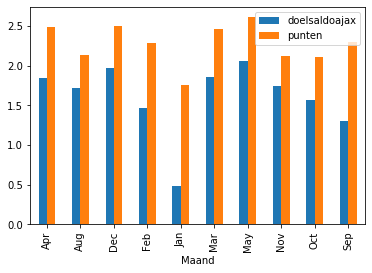

In [100]:
# plot maken van pivot-table

pivot_maand.plot(kind='bar')

Op het eerste gezicht lijken Ajax-voetballers in ieder geval niet per se beter te preseteren in de zomer-maanden dan in de winter maanden. Verder opvallend, er is duidelijk een after-winterstop dip waarneembaar. Januari is duidelijk de slechste maand. Mei is de sterkste maand, met gemiddeld het hoogste aantal punten en het meeste doelpunten verschil per wedstrijd.  

In [69]:
# correlatietabel maken 

corr = df3.corr()
corr.style.background_gradient(cmap='PuBu')

,meantemp,mintemp,maxtemp,zonuur,neerslagduur,etmaalneers,bewolkgraad,thuisdoel,uitdoel,doelsaldoajax,punten,winst
meantemp,1,0.935602,0.965343,0.227083,-0.0831496,0.0403652,-0.0504829,0.0368644,0.0670273,0.0167002,0.0142737,0.0168031
mintemp,0.935602,1,0.831191,0.00523455,0.0452639,0.136631,0.149979,0.0513801,0.0651519,-0.00346455,-0.000112595,0.00627545
maxtemp,0.965343,0.831191,1,0.401356,-0.185486,-0.0423328,-0.213435,0.0327635,0.0539607,0.0330526,0.0169492,0.0179239
zonuur,0.227083,0.00523455,0.401356,1,-0.490032,-0.383954,-0.79418,0.0209699,-0.0352745,0.0188429,0.0107855,0.0038857
neerslagduur,-0.0831496,0.0452639,-0.185486,-0.490032,1,0.824884,0.420881,0.0448683,-0.0294604,-0.0183335,-0.0349028,-0.0247437
etmaalneers,0.0403652,0.136631,-0.0423328,-0.383954,0.824884,1,0.335948,0.0691837,0.0124847,0.084964,0.038971,0.0520157
bewolkgraad,-0.0504829,0.149979,-0.213435,-0.79418,0.420881,0.335948,1,0.00684469,0.0724481,0.0253288,0.0384253,0.0549295
thuisdoel,0.0368644,0.0513801,0.0327635,0.0209699,0.0448683,0.0691837,0.00684469,1,-0.311458,0.369554,0.140994,0.168103
uitdoel,0.0670273,0.0651519,0.0539607,-0.0352745,-0.0294604,0.0124847,0.0724481,-0.311458,1,0.155999,0.105581,0.106171
doelsaldoajax,0.0167002,-0.00346455,0.0330526,0.0188429,-0.0183335,0.084964,0.0253288,0.369554,0.155999,1,0.791183,0.762913


In [77]:
# Toepassen Machine Learning(linear regression) om te checken welke variabelen het doelsaldo (per wedstrijd) van Ajax kunnen voorspellen

# voorspellers en afh. variabelen aanmaken

X = df3[['meantemp','mintemp','maxtemp','zonuur','neerslagduur','bewolkgraad']]
y = preprocessing.normalize(df3[['doelsaldoajax']])

#trainingset en testset aanmaken
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#instance aanmaken 

lm = LinearRegression()

#model fitten

lm.fit(X_train,y_train)

print(lm.coef_)

[[ 0.04940889 -0.02378811 -0.02683555  0.02770088 -0.00344982  0.07549104]]


Text(0, 0.5, 'Predicted Y')

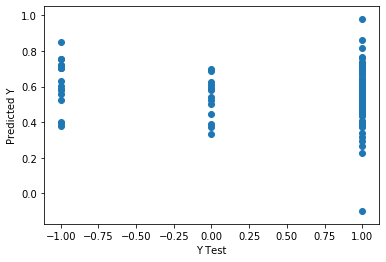

In [78]:
# checken of model op basis van trainingsdata voorspellend is

predictions = lm.predict(X_test)

plt.pyplot.scatter(y_test,predictions)
plt.pyplot.xlabel('Y Test')
plt.pyplot.ylabel('Predicted Y')

In [81]:
# get coefficients using statsmodels

X = df3[['meantemp','mintemp','maxtemp','zonuur','neerslagduur','bewolkgraad']]
Y = preprocessing.normalize(df3[["doelsaldoajax"]])
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.419
Model:                            OLS   Adj. R-squared (uncentered):              0.409
Method:                 Least Squares   F-statistic:                              40.07
Date:                Wed, 02 Oct 2019   Prob (F-statistic):                    1.26e-36
Time:                        18:44:17   Log-Likelihood:                         -353.43
No. Observations:                 339   AIC:                                      718.9
Df Residuals:                     333   BIC:                                      741.8
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
meantemp         0.0460      0.065      0.705      0.482      -0.082       0.174
mintemp         -0.0397      0.031     -1.270      0.205      -0.101       0.022
maxtemp         -0.0093      0.039     -0.237      0.812      -0.087       0.068
zonuur           0.0252      0.016      1.534      0.126      -0.007       0.058
neerslagduur    -0.0006      0.001     -0.484      0.629      -0.003       0.002
bewolkgraad      0.0666      0.013      5.114      0.000       0.041       0.092
==============================================================================
Omnibus:                       66.480   Durbin-Watson:                   2.153
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.238
Skew:                          -1.327   Prob(JB):                     6.30e-23
Kurtosis:                       3.443   Cond. No.                         82.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Hoewel de variabelen zelf weinig voorspellende waarden lijken te hebben wordt toch 40% van de variantie verklaard door de weersomstandigheden. De bewolkingsgraad lijkt relatief de sterkste voorspeller. 

In [84]:
# Toepassen Machine Learning(logistic regression) om te checken welke variabelen kunnen voorspellen of Ajax wint of niet

# voorspellers en afh. variabelen aanmaken

#voorspellers en afh. 
X = df3[['meantemp','mintemp','maxtemp','zonuur','neerslagduur','bewolkgraad']]
y = preprocessing.normalize(df3[['winst']])

#trainingset en testset aanmaken
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#instance aanmaken 

logm = LogisticRegression(solver='lbfgs')

#model fitten

logm.fit(X_train,y_train)

print(logm.coef_)

[[-0.012765   -0.0029362   0.01718183  0.10008805 -0.00838874  0.26561372]]


//anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [85]:
predictions = logm.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        31
         1.0       0.72      0.98      0.83        81

    accuracy                           0.71       112
   macro avg       0.36      0.49      0.41       112
weighted avg       0.52      0.71      0.60       112



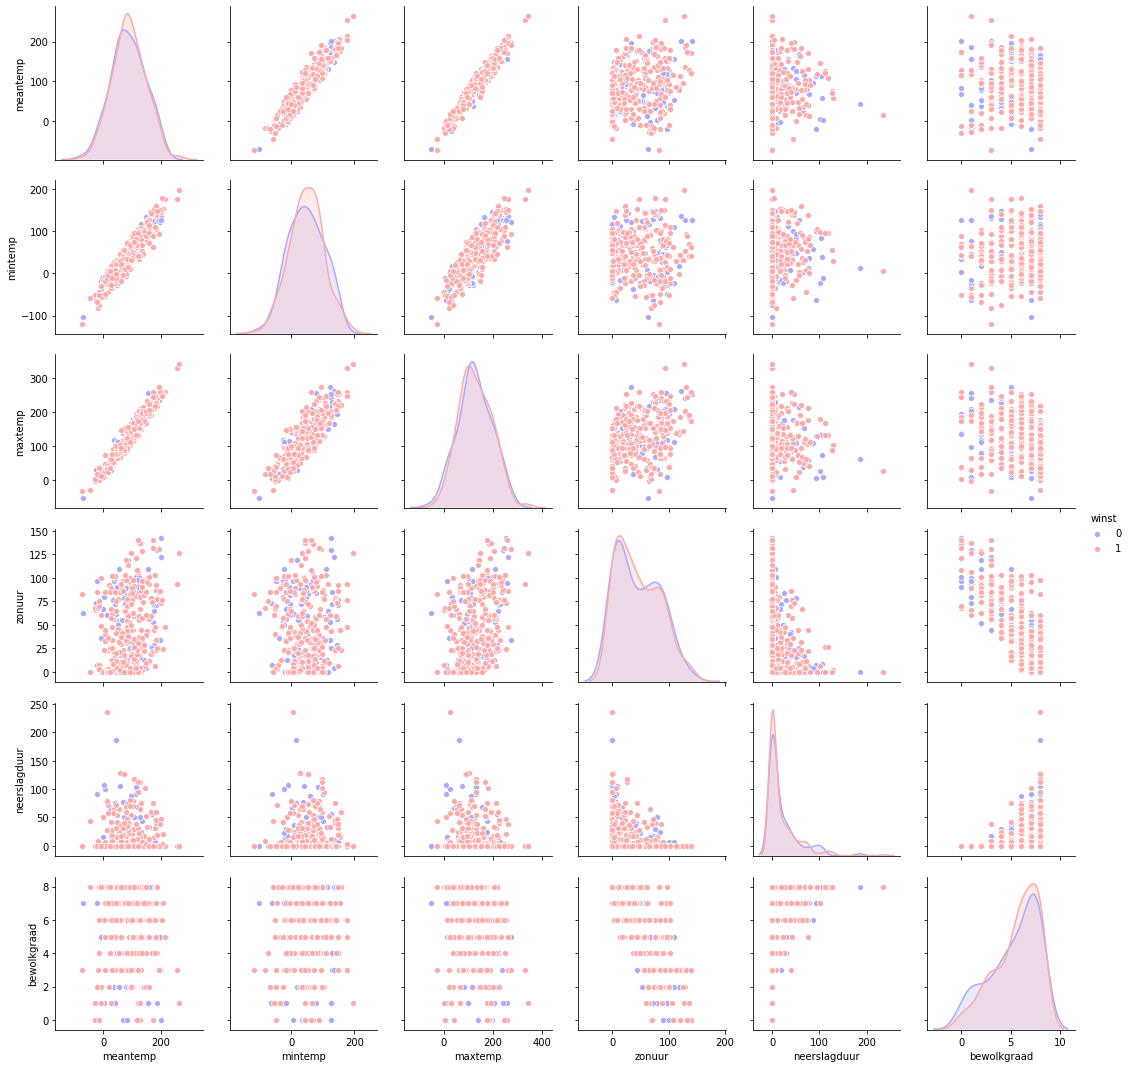

In [44]:
# visueel kijken naar voorspelling winst: 

sns.pairplot(df3,hue='winst',palette='bwr',vars=['meantemp','mintemp','maxtemp','zonuur','neerslagduur','bewolkgraad'])